## vLLM

In [ ]:
!pip install vllm lm-format-enforcer pandas streamlit chromadb vllm pypdf

In [1]:
from huggingface_hub import notebook_login, login
from google.colab import userdata

HF_KEY = userdata.get('HF_KEY')
login(token=HF_KEY)
# notebook_login()

In [ ]:
import torch
torch.cuda.empty_cache()

# Clear GPU
torch.cuda.empty_cache()

In [ ]:
import vllm
model_id = 'meta-llama/Llama-2-7b-chat-hf'
llm = vllm.LLM(model=model_id, gpu_memory_utilization=0.9, max_model_len=752)

In [ ]:
from IPython.display import display, Markdown

def display_header(text):
    display(Markdown(f'**{text}**'))

def display_content(text):
    display(Markdown(f'```\n{text}\n```'))

In [ ]:
DEFAULT_SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\nIf a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\
"""

def get_prompt(message: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f'<s>[INST] <<SYS>>\n{system_prompt}\n<</SYS>>\n\n{message} [/INST]'

In [ ]:
from lmformatenforcer import CharacterLevelParser
from lmformatenforcer.integrations.vllm import build_vllm_logits_processor, build_vllm_token_enforcer_tokenizer_data
from typing import Union, List, Optional
from vllm import SamplingParams

DEFAULT_MAX_NEW_TOKENS = 100

ListOrStrList = Union[str, List[str]]

tokenizer_data = build_vllm_token_enforcer_tokenizer_data(llm)

def vllm_with_character_level_parser(prompt: ListOrStrList, parser: Optional[CharacterLevelParser] = None) -> ListOrStrList:

    sampling_params = SamplingParams()
    sampling_params.max_tokens = DEFAULT_MAX_NEW_TOKENS
    if parser:
        logits_processor = build_vllm_logits_processor(tokenizer_data, parser)
        sampling_params.logits_processors = [logits_processor]
    # Note on batched generation:
    # For some reason, I achieved better batch performance by manually adding a loop similar to this:
    # https://github.com/vllm-project/vllm/blob/main/examples/llm_engine_example.py,
    # I don't know why this is faster than simply calling llm.generate() with a list of prompts, but it is from my tests.
    # However, this demo focuses on simplicity, so I'm not including that here.
    results = llm.generate(prompt, sampling_params=sampling_params)
    if isinstance(prompt, str):
        return results[0].outputs[0].text
    else:
        return [result.outputs[0].text for result in results]


In [ ]:
from lmformatenforcer import JsonSchemaParser
from pydantic import BaseModel


class AnswerFormat(BaseModel):
    first_name: str
    last_name: str
    year_of_birth: int
    num_seasons_in_nba: int

question = 'Please give me information about Michael Jordan. You MUST answer using the following json schema: '
question_with_schema = f'{question}{AnswerFormat.schema_json()}'
prompt = get_prompt(question_with_schema)

display_header("Prompt:")
display_content(prompt)

display_header("Answer, With json schema enforcing:")

result = vllm_with_character_level_parser(prompt, JsonSchemaParser(AnswerFormat.schema()))
display_content(result)

display_header("Answer, Without json schema enforcing:")
result = vllm_with_character_level_parser(prompt, None)
display_content(result)



<ipython-input-5-4b8c3c0cd4a9>:12: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  question_with_schema = f'{question}{AnswerFormat.schema_json()}'


**Prompt:**

```
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Please give me information about Michael Jordan. You MUST answer using the following json schema: {"properties": {"first_name": {"title": "First Name", "type": "string"}, "last_name": {"title": "Last Name", "type": "string"}, "year_of_birth": {"title": "Year Of Birth", "type": "integer"}, "num_seasons_in_nba": {"title": "Num Seasons In Nba", "type": "integer"}}, "required": ["first_name", "last_name", "year_of_birth", "num_seasons_in_nba"], "title": "AnswerFormat", "type": "object"} [/INST]
```

**Answer, With json schema enforcing:**

<ipython-input-5-4b8c3c0cd4a9>:20: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  result = vllm_with_character_level_parser(prompt, JsonSchemaParser(AnswerFormat.schema()))


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

```
  {
"first_name": "Michael",
"last_name": "Jordan",
"year_of_birth": 1963,
"num_seasons_in_nba": 15
}




```

**Answer, Without json schema enforcing:**

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

```
  Of course! I'd be happy to provide information about Michael Jordan using the provided JSON schema. Here is the information you requested:

{
"first_name": "Michael",
"last_name": "Jordan",
"year_of_birth": 1963,
"num_seasons_in_nba": 15
}

Please let me know if you have any further questions or if there's
```

In [ ]:
from time import time

players = ['Michael Jordan', 'Tim Duncan', 'Larry Bird', 'Magic Johnson', 'Patrick Ewing',
           'Hakeem Olajuwan', 'Nate Archibald', 'Charles Barkley', 'Bob Cousy', 'Clyde Drexler',
           'Julius Erving', 'John Havlicek', 'Elvin Hayes', 'Jerry Lucas', 'Moses Malone',
           'George Mikan', 'Bob Pettit', 'Oscar Robertson', 'Bill Russell', 'Dolph Schayes']
prompts = []
for player in players:
    question = f'Please give me information about {player}. You MUST answer using the following json schema: '
    question_with_schema = f'{question}{AnswerFormat.schema_json()}'
    prompt = get_prompt(question_with_schema)
    prompts.append(prompt)

start = time()
one_player_result = vllm_with_character_level_parser(prompts[0], JsonSchemaParser(AnswerFormat.schema()))
end = time()
print(f'Time taken for 1 player: {end - start}s')
display_content(one_player_result)

start = time()
all_results = vllm_with_character_level_parser(prompts[1:], JsonSchemaParser(AnswerFormat.schema()))
end = time()
print(f'Time taken for {len(prompts)-1} players: {end - start}. Time per player: {(end - start)/(len(prompts)-1)}')
display_content(all_results)

<ipython-input-6-8e7a48c95100>:10: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  question_with_schema = f'{question}{AnswerFormat.schema_json()}'
<ipython-input-6-8e7a48c95100>:15: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  one_player_result = vllm_with_character_level_parser(prompts[0], JsonSchemaParser(AnswerFormat.schema()))


Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Time taken for 1 player: 3.74741268157959s


```
  {
"first_name": "Michael Jeffrey Jordan",
"last_name": "Jordan",
"year_of_birth": 1963,
"num_seasons_in_nba": 15
}




```

<ipython-input-6-8e7a48c95100>:21: PydanticDeprecatedSince20: The `schema` method is deprecated; use `model_json_schema` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  all_results = vllm_with_character_level_parser(prompts[1:], JsonSchemaParser(AnswerFormat.schema()))


Processed prompts:   0%|          | 0/19 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

Time taken for 19 players: 42.614912033081055. Time per player: 2.242890107004266


```
['  {\n"first_name": "Timothy",\n"last_name": "Duncan",\n"year_of_birth": 1976,\n"num_seasons_in_nba": 19\n}\n\n', '  {\n"first_name": "Larry",\n"last_name": "Hbird",\n"year_of_birth": 1956,\n"num_seasons_in_nba": 13\n}', '  {\n"first_name": "Earvin",\n"last_name": "Johnson",\n"year_of_birth": 1959,\n"num_seasons_in_nba": 13\n}\n\n\n\n\n\n', '  {\n"first_name": "Patrick Maurice Ewing",\n"last_name": "Ewing",\n"year_of_birth": 1962,\n"num_seasons_in_nba": 17\n}\n\n', '  {\n"first_name": "Hakeem",\n"last_name": "Olajuwon",\n"year_of_birth": 1963,\n"num_seasons_in_nba": 17\n}\n\n\n\n\n', '  {\n"first_name": "Nate",\n"last_name": "Archibald",\n"year_of_birth": 1973,\n"num_seasons_in_nba": 11\n}\n\n\n\n\n\n', '  {\n"first_name": "Charles",\n"last_name": "W. Barkley",\n"year_of_birth": 1963,\n"num_seasons_in_nba": 16\n}\n\n\n\n\n\n\n', '  {\n"first_name": "Bob",\n"last_name": "Cousy",\n"year_of_birth": 1928,\n"num_seasons_in_nba": 13\n}', '  {\n"first_name": "Clyde",\n"last_name": "Drexler",\n"year_of_birth": 1962,\n"num_seasons_in_nba": 10\n}\n\n\n\n', '  {\n"first_name": "Julius",\n"last_name": "Erving",\n"year_of_birth": 1952,\n"num_seasons_in_nba": 16\n}\n\n', '  {\n"first_name": "John",\n"last_name": "Havlicek",\n"year_of_birth": 1949,\n"num_seasons_in_nba": 16\n}', '  {\n"first_name": "Elvin",\n"last_name": "Hayes",\n"year_of_birth": 1945,\n"num_seasons_in_nba": 10\n}\n\n\n\n\n', '  {\n"first_name": "Jerry",\n"last_name": "Lucas",\n"year_of_birth": 1944,\n"num_seasons_in_nba": 8\n}\n\n       ', '  {\n"first_name": "Moses Malone",\n"last_name": "Malone",\n"year_of_birth": 1963,\n"num_seasons_in_nba": 16\n}\n\n\n\n\n', '  {\n"first_name": "George",\n"last_name": "Mikan",\n"year_of_birth": 1924,\n"num_seasons_in_nba": 10\n}\n\n\n\n\n\n', '  {\n"first_name": "Bob",\n"last_name": "Pettit",\n"year_of_birth": 1932,\n"num_seasons_in_nba": 11\n}\n\n\n\n', '  {\n"first_name": "Oscar",\n"last_name": "Robertson",\n"year_of_birth": 1936,\n"num_seasons_in_nba": 16\n}\n\n\n\n', '  {\n"first_name": "Bill",\n"last_name": "Russell",\n"year_of_birth": 1934,\n"num_seasons_in_nba": 13\n}', '  {\n"first_name": "Dolph",\n"last_name": "Schayes",\n"year_of_birth": 1921,\n"num_seasons_in_nba": 15\n}\n\n']
```

In [ ]:
from lmformatenforcer.regexparser import RegexParser
import pandas as pd

date_regex = r'(0?[1-9]|1[0-2])\/(0?[1-9]|1\d|2\d|3[01])\/(19|20)\d{2}'
answer_regex = ' In mm/dd/yyyy format, Michael Jordan was born in ' + date_regex
parser = RegexParser(answer_regex)

question = 'When was Michael Jordan Born? Please answer in mm/dd/yyyy format.'
prompt = get_prompt(question)
display_header("Prompt:")
display_content(prompt)

# Note the analyze=True flag, which is will create an analyzer in the processor
logits_processor = build_vllm_logits_processor(tokenizer_data, parser, analyze=True)

sampling_params = SamplingParams(max_tokens=200, logits_processors=[logits_processor])
results = llm.generate(prompt, sampling_params=sampling_params)

text = results[0].outputs[0].text
display_header("Answer:")
display_content(text)

display_header("Analyzer Results:")
report_dict = logits_processor.analyzer.generate_report_dict(results[0].outputs[0].token_ids)
enforced_scores = pd.DataFrame(report_dict)
# Setting some display options for readability
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 999)
pd.set_option('display.float_format', ' {:,.5f}'.format)
display(enforced_scores)


**Prompt:**

```
<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

When was Michael Jordan Born? Please answer in mm/dd/yyyy format. [/INST]
```

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

**Answer:**

```
 In mm/dd/yyyy format, Michael Jordan was born in 02/17/1963
```

**Analyzer Results:**

,generated_token,generated_token_idx,generated_score,leading_token,leading_token_idx,leading_score
0,,29871,0.99997,,29871,0.99997
1,I,29902,0.00000,Thank,3374,0.39105
2,n,29876,0.00000,',29915,0.86539
3,,29871,0.00777,st,303,0.63228
4,mm,4317,0.00000,1,29896,0.97998
5,/,29914,0.99869,/,29914,0.99869
6,dd,1289,0.99976,dd,1289,0.99976
7,/,29914,0.99989,/,29914,0.99989
8,yyyy,18855,0.99556,yyyy,18855,0.99556
9,format,3402,0.99965,format,3402,0.99965


The timesteps in which `generated_score < leading_score` are those in which the format enforcer had to intervene. Consider using this during development to fine tune your prompts for better consistency.

This method also works for JSON Schema mode, of course.

## vLLM Server

In [ ]:
!pip install pyngrok

In [ ]:
from google.colab import userdata
NGROK_TOKEN = userdata.get('NGROK_TOKEN')

In [ ]:
!ngrok config add-authtoken $NGROK_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!ngrok http 8000

Traceback (most recent call last):
  File "/usr/lib/python3.11/subprocess.py", line 1264, in wait
    return self._wait(timeout=timeout)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 2053, in _wait
    (pid, sts) = self._try_wait(0)
                 ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/subprocess.py", line 2011, in _try_wait
    (pid, sts) = os.waitpid(self.pid, wait_flags)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/ngrok", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pyngrok/ngrok.py", line 618, in main
    run(sys.argv[1:])
  File "/usr/local/lib/python3.11/dist-packages/pyngrok/ngrok.py", line 606, in run
    process.run_process(pyngrok_config.ngrok_path, args)
  File "/usr/local/lib/python3.11/dist-packages/pyngrok/pro

In [ ]:
!ngrok http 8000 & vllm serve meta-llama/Llama-2-7b-chat-hf --max-model-len=752

INFO 05-06 02:55:55 [__init__.py:239] Automatically detected platform cuda.
2025-05-06 02:55:56.196160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746500156.218003   16495 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746500156.224667   16495 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-06 02:55:56.246704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO 05-06 02:56:06 [api_server.py:1043] 

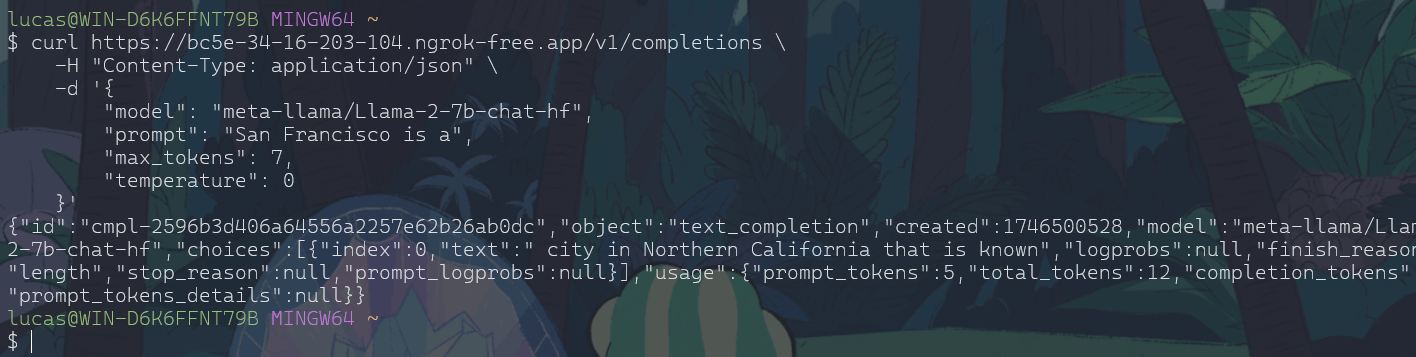

## Streamlit

In [ ]:
!pip install vllm lm-format-enforcer pandas streamlit chromadb vllm PyPDF2

In [2]:
!pip install pyngrok

In [3]:
from google.colab import userdata
NGROK_TOKEN = userdata.get('NGROK_TOKEN')

In [4]:
!ngrok config add-authtoken $NGROK_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [5]:
from huggingface_hub import notebook_login, login
from google.colab import userdata

HF_KEY = userdata.get('HF_KEY')
login(token=HF_KEY)

## vLLM

In [10]:
%%writefile app.py
import streamlit as st
import os
from PyPDF2 import PdfReader
import chromadb
from vllm import LLM
import numpy as np

llm = LLM(model="meta-llama/Llama-2-7b-chat-hf", gpu_memory_utilization=0.9, max_model_len=752)

# Função para extrair texto do PDF
def extract_text_from_pdf(pdf_file):
    pdf_reader = PdfReader(pdf_file)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

# Função para inicializar o cliente do chromadb
def init_chroma():
    client = chromadb.Client()
    return client

# Função para armazenar documento no ChromaDB
def store_document_in_chroma(client, document_text, collection_name="documents"):
    collection = client.create_collection(name=collection_name)
    collection.add(
        documents=[document_text],
        metadatas=[{"source": "uploaded_pdf"}],
        ids=["doc_1"]
    )

# Função para buscar uma resposta com vLLM
def get_answer_from_llm(question, context):
    prompt = f"Question: {question}\nContext: {context}\nAnswer:"
    response = llm.generate(prompt)
    return response['text']

# Interface Streamlit
st.title("Document QA with vLLM and Chromadb")

# Upload do documento
uploaded_file = st.file_uploader("Upload a document", type=["pdf", "txt"])

if uploaded_file:
    if uploaded_file.type == "application/pdf":
        document_text = extract_text_from_pdf(uploaded_file)
    else:
        document_text = uploaded_file.getvalue().decode("utf-8")

    # Inicializa o cliente do chromadb e armazena o documento
    client = init_chroma()
    store_document_in_chroma(client, document_text)

    st.success("Documento carregado com sucesso!")

    # Pergunta do usuário
    question = st.text_input("Digite sua pergunta:")

    if question:
        # Recupera a resposta do LLM
        answer = get_answer_from_llm(question, document_text)
        st.write(f"Resposta: {answer}")


Writing app.py


## vLLM externo

In [45]:
%%writefile app.py
import streamlit as st
import requests
import json
from PyPDF2 import PdfReader
import chromadb
from langchain.text_splitter import CharacterTextSplitter

prompt_template = """
Você é um assistente que precisa responder às dúvidas de um usuário com base em um documento fornecido como contexto.

Esse é o documento:
{context}

Essa é a pergunta do usuário:
{question}

Responda a pergunta do usuário com base no documento fornecido.
"""

def extract_text_from_pdf(pdf_file):
    pdf_reader = PdfReader(pdf_file)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

def store_document_in_chroma(client, document_text, collection_name="documents"):
    text_splitter = CharacterTextSplitter(chunk_size=128, chunk_overlap=0)
    texts = text_splitter.split_text(document_text)
    collection = client.get_or_create_collection(name=collection_name)
    collection.add(
        documents=texts,
        metadatas=[{"source": "uploaded_pdf"}] * len(texts),
        ids=[f"doc_{i}" for i in range(len(texts))]
    )

def retrieve_relevant_documents(client, question, collection_name="documents", n_results=1):
    collection = client.get_collection(name=collection_name)
    results = collection.query(
        query_texts=[question],
        n_results=n_results
    )
    return results["documents"]

def get_answer_from_llm(question, context):
    prompt = prompt_template.format(context=context, question=question)
    print("prompt", prompt)
    url = "http://localhost:8000/v1/chat/completions"
    headers = {"Content-Type": "application/json"}
    payload = {
        "model": "clibrain/Llama-2-7b-ft-instruct-es-gptq-4bit",
        "messages": [
            {"role": "system", "content": "Você é um assistente útil."},
            {"role": "user", "content": prompt},
        ],
        "max_tokens": 512
    }
    response = requests.post(url, headers=headers, data=json.dumps(payload))
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        return "Erro ao obter resposta do modelo."

st.title("Document QA with vLLM and ChromaDB")

uploaded_file = st.file_uploader("Upload a document", type=["pdf", "txt"])

if uploaded_file:
    document_text = uploaded_file.getvalue().decode("utf-8") if uploaded_file.type == "text/plain" else extract_text_from_pdf(uploaded_file)
    client = chromadb.Client()
    store_document_in_chroma(client, document_text)
    st.success("Documento carregado com sucesso!")

    question = st.text_input("Digite sua pergunta:")
    if question:
        context = retrieve_relevant_documents(client, question)
        answer = get_answer_from_llm(question, context)
        st.write(f"Resposta: {answer}")


Overwriting app.py


In [46]:
%%writefile chat_template.jinja
{% for message in messages %}
    {% if message['role'] == 'user' %}
        [USER]: {{ message['content'] }}
    {% elif message['role'] == 'assistant' %}
        [ASSISTANT]: {{ message['content'] }}
     {% elif message['role'] == 'system' %}
        [SYSTEM]: {{ message['content'] }}
    {% endif %}
{% endfor %}

Overwriting chat_template.jinja


In [47]:
!vllm serve clibrain/Llama-2-7b-ft-instruct-es-gptq-4bit \
  --chat-template ./chat_template.jinja \
    --max-model-len 16000 \
    --quantization awq \
    --gpu-memory-utilization 0.95 \
    --chat-template-content-format string \
    & streamlit run app.py \
    & ngrok http 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.19.46.130:8501

INFO 05-10 16:50:58 [__init__.py:239] Automatically detected platform cuda.
2025-05-10 16:51:00.134901: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746895860.179264   45141 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746895860.191717   45141 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 16:51:00.237907: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

## vLLM Stream

In [54]:
%%writefile app.py
import streamlit as st
import requests
import json
from PyPDF2 import PdfReader
import chromadb
from langchain.text_splitter import CharacterTextSplitter

prompt_template = """
Você é um assistente que precisa responder às dúvidas de um usuário com base em um documento fornecido como contexto.

Esse é o documento:
{context}

Essa é a pergunta do usuário:
{question}

Responda a pergunta do usuário com base no documento fornecido.
"""

def extract_text_from_pdf(pdf_file):
    pdf_reader = PdfReader(pdf_file)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

def store_document_in_chroma(client, document_text, collection_name="documents"):
    text_splitter = CharacterTextSplitter(chunk_size=128, chunk_overlap=0)
    texts = text_splitter.split_text(document_text)
    collection = client.get_or_create_collection(name=collection_name)
    collection.add(
        documents=texts,
        metadatas=[{"source": "uploaded_pdf"}] * len(texts),
        ids=[f"doc_{i}" for i in range(len(texts))]
    )

def retrieve_relevant_documents(client, question, collection_name="documents", n_results=1):
    collection = client.get_collection(name=collection_name)
    results = collection.query(
        query_texts=[question],
        n_results=n_results
    )
    return results["documents"]

def get_answer_from_llm(question, context):
    prompt = prompt_template.format(context=context, question=question)
    print("prompt", prompt)
    url = "http://localhost:8000/v1/chat/completions"
    headers = {"Content-Type": "application/json"}
    payload = {
        "model": "clibrain/Llama-2-7b-ft-instruct-es-gptq-4bit",
        "messages": [
            {"role": "system", "content": "Você é um assistente útil."},
            {"role": "user", "content": prompt},
        ],
        "stream": True,
        "max_tokens": 512
    }
    response = requests.post(url, headers=headers, data=json.dumps(payload), stream=True)
    if response.status_code == 200:
        for line in response.iter_lines():
            if line:
                decoded_line = line.decode("utf-8")
                if decoded_line.startswith("data:"):
                    data = decoded_line[5:].strip()
                    if data == "[DONE]":
                        break
                    try:
                        chunk = json.loads(data)
                        content = chunk["choices"][0]["delta"].get("content", "")
                        if content:
                            yield content
                    except json.JSONDecodeError:
                        continue
    else:
        yield "Erro ao obter resposta do modelo."

st.title("Document QA with vLLM and ChromaDB")

uploaded_file = st.file_uploader("Upload a document", type=["pdf", "txt"])

if uploaded_file:
    document_text = uploaded_file.getvalue().decode("utf-8") if uploaded_file.type == "text/plain" else extract_text_from_pdf(uploaded_file)
    client = chromadb.Client()
    store_document_in_chroma(client, document_text)
    st.success("Documento carregado com sucesso!")

    question = st.text_input("Digite sua pergunta:")
    if question:
        context = retrieve_relevant_documents(client, question)
        answer_placeholder = st.empty()
        response = ""
        for answer_chunk in get_answer_from_llm(question, context):
            response += answer_chunk
            answer_placeholder.markdown(response)


Overwriting app.py


In [ ]:
!vllm serve clibrain/Llama-2-7b-ft-instruct-es-gptq-4bit \
  --multi-step-stream-outputs \
  --chat-template ./chat_template.jinja \
    --max-model-len 4096 \
    --quantization gptq \
    --gpu-memory-utilization 0.95 \
    --chat-template-content-format string \
    & streamlit run app.py \
    & ngrok http 8501

Essa é a resposta: Este é um documento sobre "Parallel e Scalable Dunn Index para Validation of Big Data Clusters"

Seu inglês ficará péssimo, em vez de tudo isso.

Essa é uma área não programátil que precisa ser atendida por modelo de lógica. Não se precisam milhões de ecuações dedutivas anotáveis ou redutríveis a máquinas. O resultado é mais um conhecimento no projeto.

Para automate ta roxima, possível até mesmo texto. A herança e desenvolvimento de conhecimentos estão atrasados dos avanços tecnológicos.

Em vez de expor consistentemente a coordenação das atividades mentais humanas, as ciências sociais, comunicação, criação/transmissão de conhecimentos, sejam qual elas, com e sem modelizar nos comunicária tecnológica, foco no conteúdo da pessoa e sua habilidade a expressarlo-lo de uma forma significante e significada, não nos faz progressar em nada.



## Ollama

In [59]:
!pip install ollama
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [63]:
!pip install colab-xterm
%load_ext colabxterm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.6/115.6 kB 4.0 MB/s eta 0:00:00


In [96]:
!ps aux | grep ngrok

root       64503  0.0  0.1  31400 22388 pts/0    T    18:04   0:00 /usr/bin/python3 /usr/local/bin/ngrok http 8501
root       64504  0.0  0.2 1254568 30036 pts/0   Tl   18:04   0:00 /root/.config/ngrok/ngrok http 8501
root       64982  0.0  0.0   7376  3348 ?        S    18:05   0:00 /bin/bash -c ps aux | grep ngrok
root       64984  0.0  0.0   7376   284 ?        R    18:05   0:00 /bin/bash -c ps aux | grep ngrok


In [ ]:
%xterm

In [65]:
!ollama pull llama2:7b

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling 8934d96d3f08:   0% ▕▏  59 KB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   1% ▕▏  46 MB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   3% ▕▏  98 MB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   3% ▕▏ 125 MB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   4% ▕▏ 163 MB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   5% ▕▏ 209 MB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   6% ▕▏ 226 MB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   6% ▕▏ 230 MB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   6% ▕▏ 230 MB/3.8 GB                  pulling manifest 
pulling 8934d96d3f08:   6% ▕▏ 231 MB/3.8 GB                  pulling manifest 
pu

In [74]:
%%writefile app.py
import streamlit as st
import requests
import json
from PyPDF2 import PdfReader
import chromadb
from langchain.text_splitter import CharacterTextSplitter

import ollama

def get_answer_from_ollama(question, context):
    prompt = f"""
    Você é um assistente que precisa responder às dúvidas de um usuário com base em um documento fornecido como contexto.

    contexto:
    {context}

    pergunta:
    {question}

    Resposta:
    """
    print("Prompt:", prompt)

    stream = ollama.chat(
        model="llama2:7b",
        messages=[
            {"role": "system", "content": "Você é um assistente útil."},
            {"role": "user", "content": prompt},
        ],
        stream=True,
    )

    resposta = ""
    for chunk in stream:
        conteudo = chunk['message']['content']
        if conteudo:
            resposta += conteudo
            print(conteudo, end='', flush=True)

    return resposta

def extract_text_from_pdf(pdf_file):
    pdf_reader = PdfReader(pdf_file)
    text = ""
    for page in pdf_reader.pages:
        text += page.extract_text()
    return text

def store_document_in_chroma(client, document_text, collection_name="documents"):
    text_splitter = CharacterTextSplitter(chunk_size=128, chunk_overlap=0)
    texts = text_splitter.split_text(document_text)
    collection = client.get_or_create_collection(name=collection_name)
    collection.add(
        documents=texts,
        metadatas=[{"source": "uploaded_pdf"}] * len(texts),
        ids=[f"doc_{i}" for i in range(len(texts))]
    )

def retrieve_relevant_documents(client, question, collection_name="documents", n_results=1):
    collection = client.get_collection(name=collection_name)
    results = collection.query(
        query_texts=[question],
        n_results=n_results
    )
    return results["documents"]


st.title("Document QA with Ollama and ChromaDB")

uploaded_file = st.file_uploader("Upload a document", type=["pdf", "txt"])

if uploaded_file:
    document_text = uploaded_file.getvalue().decode("utf-8") if uploaded_file.type == "text/plain" else extract_text_from_pdf(uploaded_file)
    client = chromadb.Client()
    store_document_in_chroma(client, document_text)
    st.success("Documento carregado com sucesso!")

    question = st.text_input("Digite sua pergunta:")
    if question:
        context = retrieve_relevant_documents(client, question)
        answer_placeholder = st.empty()
        response = ""
        for answer_chunk in get_answer_from_ollama(question, context):
            response += answer_chunk
            answer_placeholder.markdown(response)


Overwriting app.py


In [91]:
!streamlit run app.py \
    & ngrok http 8501

curl: (7) Failed to connect to localhost port 11434 after 0 ms: Connection refused


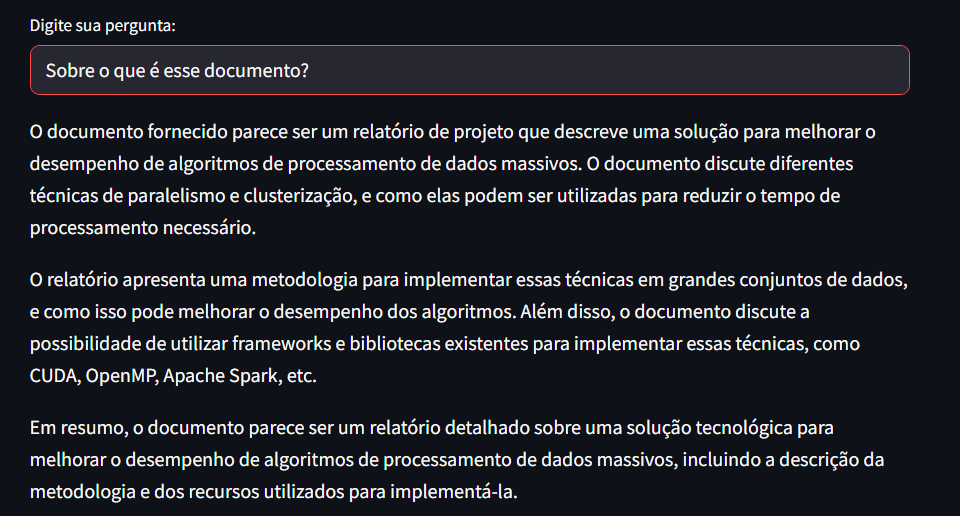